In [13]:
'''
This notebook is designed to iterate through a polygon shapefile and extract Landsat
based fractional cover information based on a user specified time interval. The 
monthly percentile values are then calculated and saved to netcdf.
'''

import os
from datacube import Datacube
from datacube.utils import geometry
from datacube.storage.masking import mask_invalid_data
from datacube_stats.statistics import Percentile

import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/dea-notebooks/10_Scripts'))
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/burn-mapping/notebooks/handover'))
dc = Datacube(app='multipoly_extract')

import fiona
import rasterio.features
import DEADataHandling
import xarray as xr

In [2]:
#%matplotlib inline
#import datacube
#from BurnCube import BurnCube 
#bc = BurnCube()

In [3]:
# Set this to the location you have saved your extraction polygons
shape_file = os.path.expanduser('/g/data1a/r78/DPIPWE_lm/input_data/Wombat_mange_aois.shp')

In [4]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [5]:
results = '/g/data/r78/DPIPWE_lm/output_data/'
working_directory = '/g/data/r78/DPIPWE_lm/'
data = working_directory + 'input_data/'

# Name of shapefile containing polygons
shapefile_loc = data + 'Wombat_mange_aois.shp'

product = 'fc'

#start and end date of the timeseries of interest (usually shouldn't need to change this)
startdate = '2017-01-01'
enddate = '2019-11-18'

## Set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene.
#Scenes will not be retrieved that have less than the cloud threshold worth of image.
cloud_free_threshold = 0.90

In [6]:
with fiona.open(shape_file) as input:
    crs = geometry.CRS(input.crs_wkt)
    #print(crs)
    for feat in input:
        aoi = (feat['properties']['AOI'])
        coords = (feat['geometry'])
        geom = geometry.Geometry(coords, crs=crs)  #why does this work?
        sdate = (feat['properties']['START_DATE'])
        edate = (feat['properties']['END_DATE'])
        
        query = {'geopolygon': geom,
         'time': (startdate, enddate)        
         }
        
        try: #spit into seperate cubes depending on feature name?? Also spit output names into a list
            fc25data = DEADataHandling.load_clearlandsat(dc=dc, query=query, product = product,
                                                         #sensors = sens_list, # maybe not needed
                                                         #bands_of_interest = bands,
                                                         mask_pixel_quality=True,
                                                         mask_invalid_data=True,
                                                         ls7_slc_off=True)
        # #complain if the file already exists but don't fail
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))
            
        #implement polygon mask operation here
        data = mask_invalid_data(fc25data)
        mask = geometry_mask([geom], data.geobox, invert=True)
        data = data.where(mask)
        
    print('End of for loop...' )

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 51 filtered ls7 timesteps
Loading ls8
    Loading 65 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 51 filtered ls7 timesteps
Loading ls8
    Loading 65 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
End of for loop...


In [7]:
data = data.drop(['UE', 'data_perc'])

In [8]:
data

<xarray.Dataset>
Dimensions:  (time: 116, x: 292, y: 234)
Coordinates:
  * y        (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x        (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
  * time     (time) datetime64[ns] 2017-01-07T23:52:05 ... 2019-10-28T23:52:17
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [14]:
#If percentiles are needed (calculated for entire region and entire epoch)
#Calculate this on a combo of all polygon shapes
percentiles = [0, 5, 20, 50, 80, 95, 100]
FC_percents = Percentile(percentiles)

In [16]:
FC_percentiles = FC_percents.compute(data)

In [17]:
FC_percentiles.attrs = data.attrs

In [18]:
FC_percentiles

<xarray.Dataset>
Dimensions:     (x: 292, y: 234)
Coordinates:
  * y           (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x           (x) float64 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
Data variables:
    BS_PC_0     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_0     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_0    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_5     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_5     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_5    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_20    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_20    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_20   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_50    (y, x) float64 nan nan nan nan nan nan ... nan

In [9]:
# resample to the monthly scale so we have a equal interval timeseries for the trend analysis
# This also helps reduce the size of the dataset which speeds up operations. But it also reduces the
# number of datapoints for the variability analysis, so there's a tradeoff here.
fc_med = data.resample(skipna=True, time='QS-DEC', keep_attrs=True).median() #simple median v mean?
fc_med = fc_med.rename({"BS":"BS_MED", "PV":"PV_MED", "NPV":"NPV_MED"}) #option to rename variables

fc_std = data.resample(skipna=True, time='QS-DEC', keep_attrs=True).std() #calculate std?
fc_std = fc_std.rename({"BS":"BS_STD", "PV":"PV_STD", "NPV":"NPV_STD"}) #option to rename variables

In [11]:
fc_med

<xarray.Dataset>
Dimensions:  (time: 12, x: 292, y: 234)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2019-09-01
  * y        (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x        (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
Data variables:
    BS_MED   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV_MED   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV_MED  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [19]:
# Option to merge median and std variables into one dataset?
combined_fc = xr.concat([fc_med, fc_std], dim='time') # concat not right - maybe merge?
combined

In [65]:
fc_resampled # why has the crs attribute been dropped?

<xarray.Dataset>
Dimensions:  (time: 12, x: 292, y: 234)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2019-09-01
  * y        (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x        (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [60]:
fc_resampled.attrs = data.attrs # attributes (EPSG) reassigned - not sure why keep_attrs flag doesn't work

In [61]:
fc_resampled

<xarray.Dataset>
Dimensions:  (time: 12, x: 292, y: 234)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2019-09-01
  * y        (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x        (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [62]:
da = fc_resampled

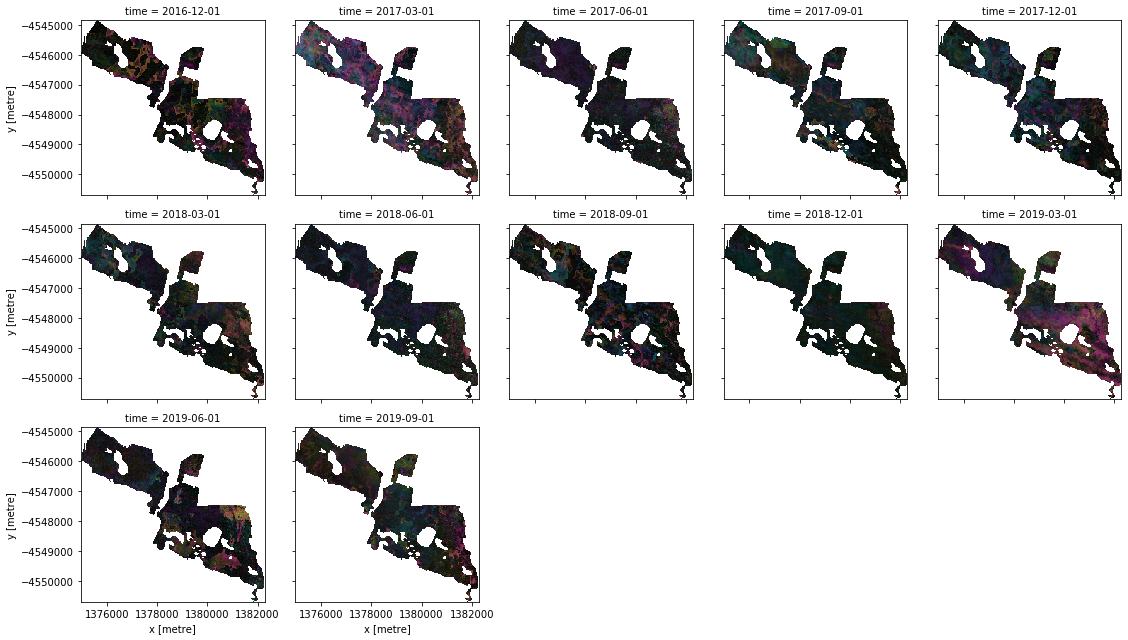

In [63]:
fake_saturation = 80
rgb = da.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(x=da.crs.dimensions[1], y=da.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)

In [ ]:
        '''
        Mask to the polygon boundary
        '''
        data = mask_invalid_data(data)
        mask = geometry_mask([geom], data.geobox, invert=True)
        data = data.where(mask)
        
        '''
        Save to ncdf
        '''
        name = aoi + '_' + str(sdate) + '_' + str(edate) + '.nc'
        try:
            DEADataHandling.write_your_netcdf(data, 'FC_time_series', 
                                              '/g/data1a/r78/DPIPWE_lm/output_data/' + name, crs = data.crs)
        # #complain if the file already exists but don't fail
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))
        print('wrote to netCDF' )
        #datacube.storage.storage.write_dataset_to_netcdf(data, 
        #                                                    '/g/data1a/r78/DPIPWE_lm/output_data/' + name)

In [24]:
fc25data

<xarray.Dataset>
Dimensions:    (time: 115, x: 292, y: 234)
Coordinates:
  * y          (y) float64 -4.545e+06 -4.545e+06 ... -4.551e+06 -4.551e+06
  * x          (x) float64 1.375e+06 1.375e+06 1.375e+06 ... 1.382e+06 1.382e+06
  * time       (time) datetime64[ns] 2017-01-07T23:52:05 ... 2019-10-20T23:36:14.500000
Data variables:
    blue       (time, y, x) float64 392.0 405.0 427.0 ... 257.0 255.0 278.0
    green      (time, y, x) float64 651.0 653.0 665.0 ... 390.0 388.0 391.0
    red        (time, y, x) float64 560.0 600.0 642.0 ... 417.0 435.0 381.0
    nir        (time, y, x) float64 3.155e+03 2.999e+03 ... 1.815e+03 1.655e+03
    swir1      (time, y, x) float64 2.02e+03 2.029e+03 ... 1.503e+03 984.0
    swir2      (time, y, x) float64 1.01e+03 1.058e+03 1.176e+03 ... 823.0 482.0
    data_perc  (time, y, x) float64 0.9943 0.9943 0.9943 ... 0.9727 0.9727
Attributes:
    crs:      EPSG:3577

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

In [23]:
data

<xarray.Dataset>
Dimensions:  (time: 62, x: 243, y: 213)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:52:05 ... 2019-09-10T23:52:08
  * y        (y) float64 -4.541e+06 -4.541e+06 ... -4.546e+06 -4.546e+06
  * x        (x) float64 1.37e+06 1.37e+06 1.37e+06 ... 1.376e+06 1.376e+06
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    UE       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

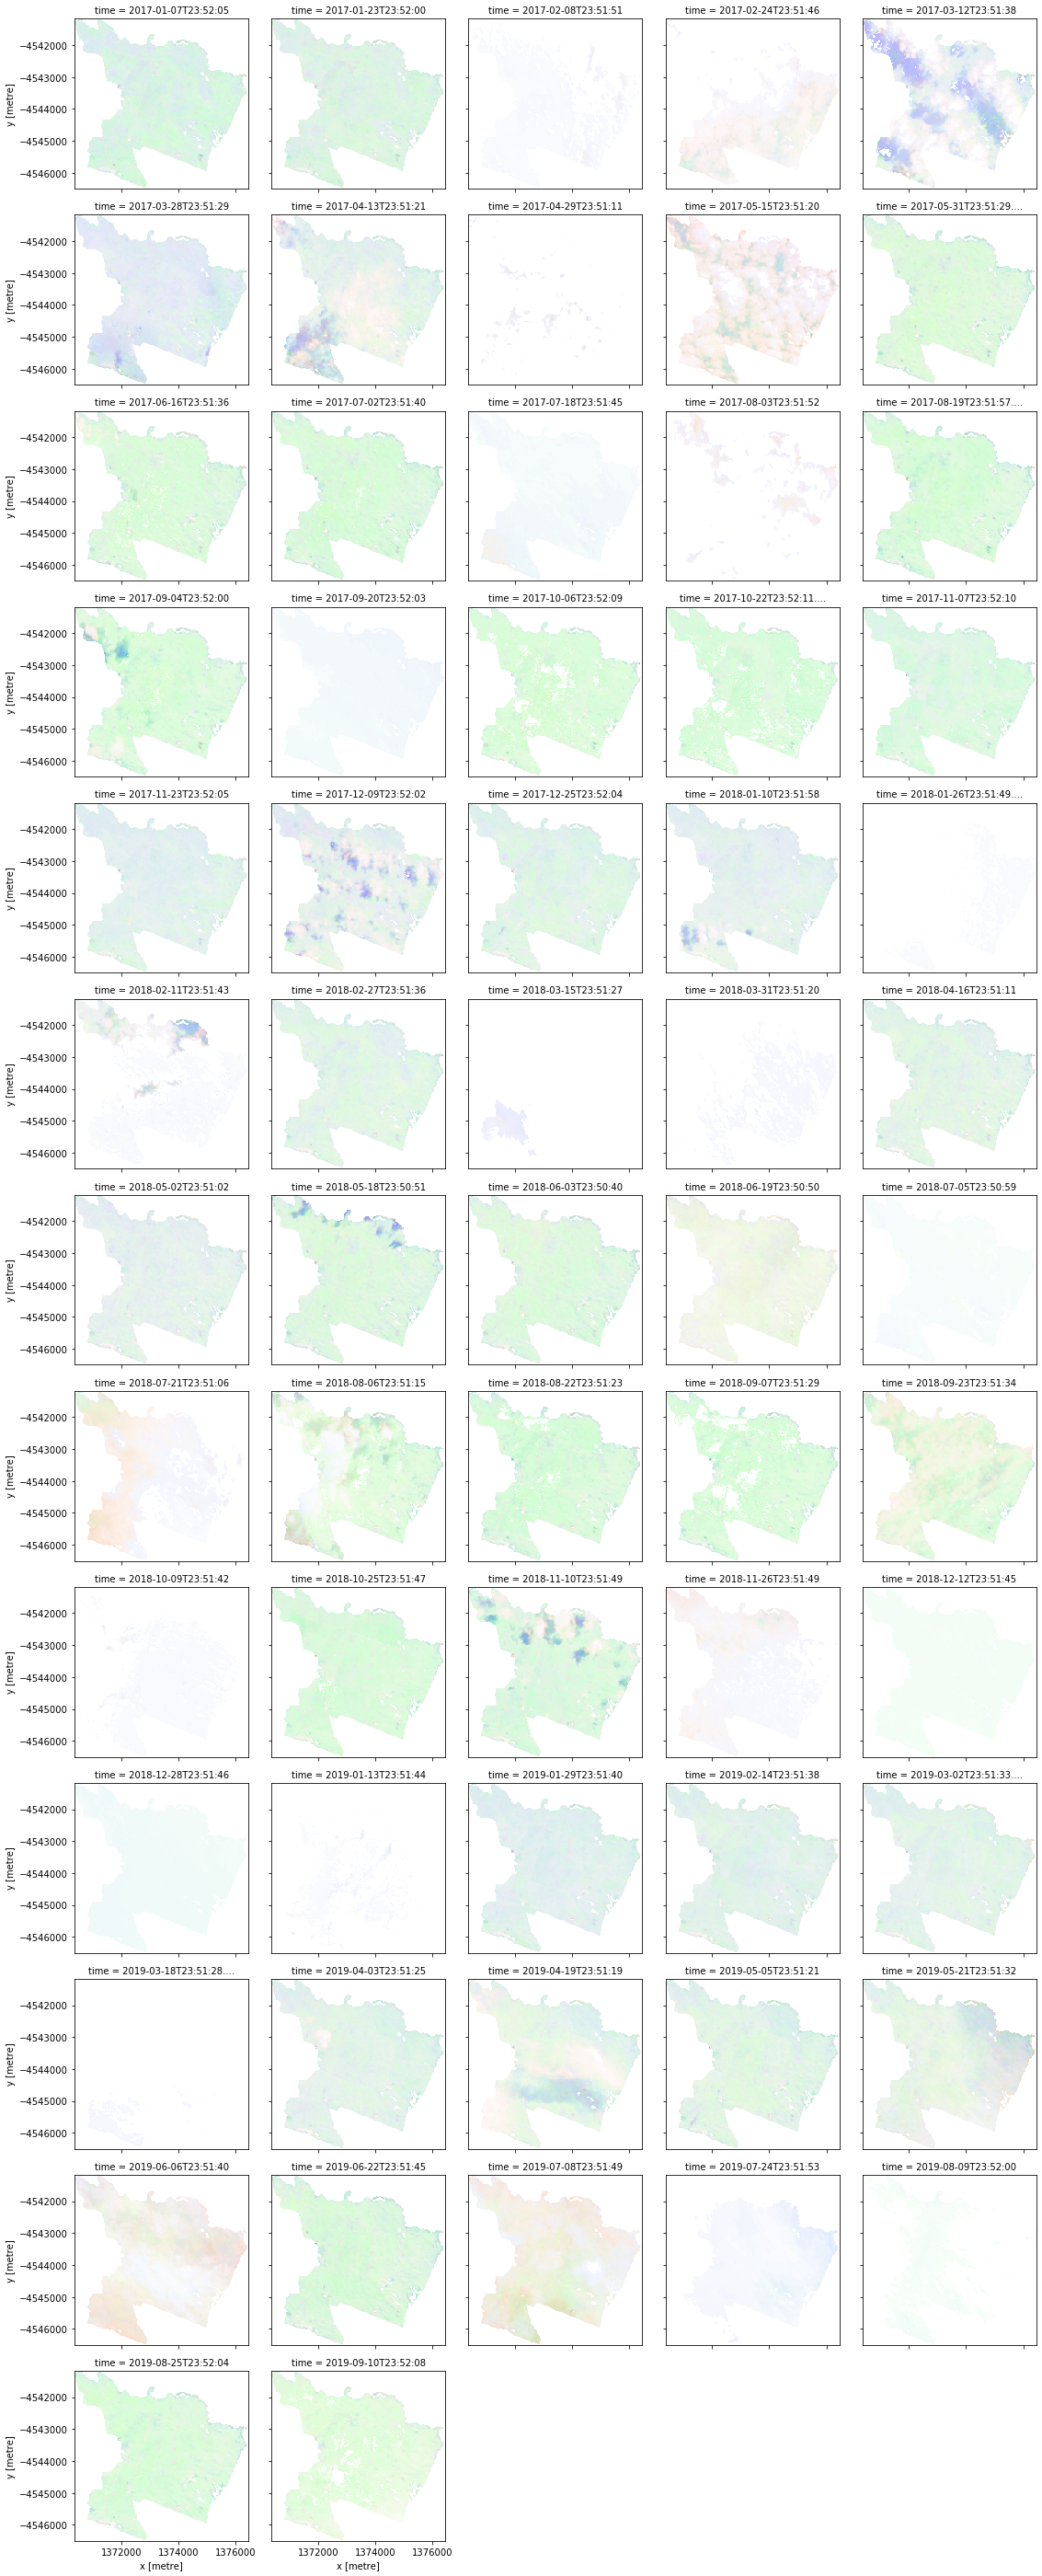

In [24]:
fake_saturation = 80
rgb = data.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)

In [14]:
#print (coords)

In [5]:
'''
Group line by line processing into one spot
'''
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)
        sen = (rec['properties']['SENSOR'])
        sdate = (rec['properties']['START_DATE'])
        sdate = str(sdate)
        edate = (rec['properties']['END_DATE'])

print(sen)
print(sdate)
print(edate)        

NameError: name 'rec' is not defined

In [ ]:
shapes = fiona.open(shape_file)

In [ ]:
crs = geometry.CRS(shapes.crs_wkt)
#crs

In [ ]:
rec = next(shapes)

In [ ]:
sen = (rec['properties']['SENSOR'])
sdate = (rec['properties']['START_DATE'])
sdate = str(sdate)
edate = (rec['properties']['END_DATE'])
#sdate = '(\'' + str(sdate) + '\')'
print(sen)
print(sdate)
print(edate)

In [ ]:
rec

In [15]:
coords = (rec['geometry'])
geom = geometry.Geometry(coords, crs)
geom

NameError: name 'rec' is not defined

In [ ]:
if sen == "Landsat":
    product = 'ls8_fc_albers'
#elif sen == 'S2':    
#    product = sen + '_ard_granule'
else:
    print('invalid sensor')

print(product) 

In [ ]:
#shapes.close()

In [ ]:
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

In [ ]:
geom

In [ ]:
query = {'geopolygon': geom,
         'time': (sdate, edate),
         'product': product
         }

In [ ]:
data = dc.load(**query)

In [ ]:
data

In [ ]:
data = mask_invalid_data(data)
  
mask = geometry_mask([geom], data.geobox, invert=True)
data = data.where(mask)

In [ ]:
fake_saturation = 80
rgb = data.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)